In [17]:
# import packages
import pandas as pd
import numpy as np
import warnings
import random
import os
warnings.filterwarnings(action="ignore")

from catboost import CatBoostRegressor, CatBoostClassifier, Pool

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from sklearn.inspection import permutation_importance

# output csv에 시간 지정해주기 위함
from datetime import datetime

In [18]:
data_dir = "/opt/ml/input/data/"

train_data = pd.read_csv(os.path.join(data_dir, "train_data.csv"))
test_data = pd.read_csv(os.path.join(data_dir, "test_data.csv"))

# 유저별 sequence로 다루기 위해 아래와 같이 정렬
train_data.sort_values(by=["userID", "Timestamp"], inplace=True)
test_data.sort_values(by=["userID", "Timestamp"], inplace=True)

### train_test_split_mode_1 / train_test_split_mode_2
docstring 부분을 참고해주세요!

In [19]:
"""
train_test_split_mode_1:
    train: train data * ratio
    valid: train data * (1 - ratio)
"""
# train과 valid 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def train_test_split_mode_1(df:pd.DataFrame, ratio=0.8, split=True):
    users = list(zip(df["userID"].value_counts().index, df["userID"].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio * len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)

    train = df[df["userID"].isin(user_ids)]
    valid = df[df["userID"].isin(user_ids) == False]

    #valid데이터셋은 각 유저의 마지막 interaction만 추출
    valid = valid[valid["userID"] != valid["userID"].shift(-1)]
    return train, valid

In [20]:
"""
train_test_split_mode_2:
    train: train data
    valid: test data에서 마지막에서 두번째 데이터까지 사용
"""
def train_test_split_mode_2(train_df:pd.DataFrame, test_df:pd.DataFrame):
    valid = test_df[test_df["answerCode"] != -1]
    valid = valid[valid["userID"] != valid["userID"].shift(-1)]
    return train_df, test_df, valid

In [21]:
def feature_engineering(df):
    # 유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    # 유저별로 정렬하고 시간순으로 정렬
    df.sort_values(by=["userID","Timestamp"], inplace=True)

    # 유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    """
    "user_correct_answer":
        유저별로 해당 문제를 풀기 전까지 정답을 맞힌 문제 수
    "user_total_answer":
        유저별로 해당 문제를 풀기 전까지 푼 문제 수
    "user_acc":
        유저별로 해당 문제를 풀기 전까지의 정답률
    """
    df["user_correct_answer"] = df.groupby("userID")["answerCode"].transform(lambda x: x.cumsum().shift(1))
    df["user_total_answer"] = df.groupby("userID")["answerCode"].cumcount()
    df["user_acc"] = df["user_correct_answer"]/df["user_total_answer"]

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    """
    "test_mean":
        특정 시험의 평균 정답 수
    "test_sum":
        푼 시험의 총 정답 수
    """
    correct_t = df.groupby(["testId"])["answerCode"].agg(["mean", "sum"])
    correct_t.columns = ["test_mean", "test_sum"]
    """
    "tag_mean":
        특정 태그의 평균 정답 수
    "tag_sum":
        푼 태그의 총 정답 수
    """
    correct_k = df.groupby(["KnowledgeTag"])["answerCode"].agg(["mean", "sum"])
    correct_k.columns = ["tag_mean", "tag_sum"]

    df = pd.merge(df, correct_t, on=["testId"], how="left")
    df = pd.merge(df, correct_k, on=["KnowledgeTag"], how="left")
    
    # 첫 세 자리 feature 추가하는 코드
    df2 = df.copy()
    df2["first_3"] = df["assessmentItemID"].str[1:4].to_frame()
    df2 = df2[["testId","first_3"]].drop_duplicates(["testId"])
    df = pd.merge(df, df2, on="testId", how="left")
    
    # 카테고리형 feature
# 여기에 범주형 feature들 이름을 추가해주세요!
    categories = ["KnowledgeTag",
                  "first_3",]
    # 카테고리형 feature를 수치형 feature로 변환해주는 작업
    le = preprocessing.LabelEncoder()
    for category in categories:
        if df[category].dtypes != "int":
            df[category] = le.fit_transform(df[category])
        df[category] = df[category].astype("category")
    return df

In [22]:
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

In [23]:
# 사용할 Feature 설정
# 캐글 솔루션에서 이렇게 feature 많을 때 Enter키로 구분하는데 보기가 편해서 적용했어요
# (나중에 지우고 싶으면 바로 주석 처리해서 지워도 되서 좋은 듯)
FEATS = ['KnowledgeTag',
         'user_correct_answer', 
         'user_total_answer', 
         'user_acc', 
         'test_mean', 
         'test_sum', 
         'tag_mean',
         'tag_sum', 
         'first_3']
########################################################### 여기서 모드 변경해주세요 ###########################################################
train_test_split_mode = 1

"""
train_test_split_mode_1:
    train: train data * ratio
    valid: train data * (1 - ratio)

train_test_split_mode_2:
    train: train data
    valid: test data에서 마지막에서 두번째 데이터까지 사용
"""
if train_test_split_mode == 1:
    train, valid = train_test_split_mode_1(train_data)
    
    X_train = train.drop(['answerCode'], axis=1)
    y_train = train['answerCode']

    X_valid = valid.drop(['answerCode'], axis=1)
    y_valid = valid['answerCode']

else:
    train, test, valid = train_test_split_mode_2(train_data, test_data)
    X_train = train.drop(['answerCode'], axis=1)
    y_train = train['answerCode']

    X_valid = valid.drop(['answerCode'], axis=1)
    y_valid = valid['answerCode']

In [24]:
cat_features = train[FEATS].columns[train[FEATS].dtypes == "category"].to_list()
cat_features

['KnowledgeTag', 'first_3']

### CatBoostRegressor

In [25]:
# CatBoostRegressor 사용
params = {
    "iterations": 150,
    "learning_rate": 0.1,  # 0.1
    "eval_metric": "AUC",
    "random_seed": 42,
    "logging_level": "Silent", # 매 epoch마다 로그를 찍고 싶으면 "logging_level": "Verbose"로 변경
    "early_stopping_rounds": 100,
    "task_type": "GPU",
    'depth':12
}

model = CatBoostRegressor(
    **params,
    cat_features=cat_features,
    allow_writing_files=False,
)

model.fit(
    train[FEATS],
    y_train,
    eval_set=[(valid[FEATS], y_valid)],
    # plot=True, # plot 찍고 싶으면 주석 제거
)

preds = model.predict(valid[FEATS])
acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_valid, preds)

print(f"VALID AUC : {auc} ACC : {acc}\n")

VALID AUC : 0.6909470014562464 ACC : 0.5840118430792006



Text(0.5, 1.0, 'permutation_importance')

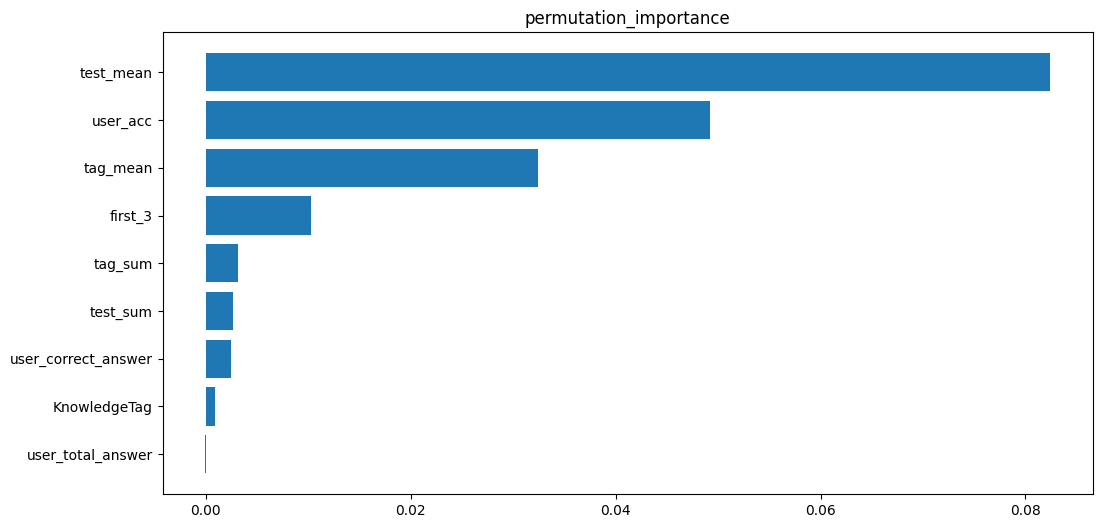

In [26]:
result = permutation_importance(model, X_valid[FEATS], y_valid, scoring = "roc_auc", n_repeats=30, random_state=42)
sorted_result = result.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(FEATS)), result.importances_mean[sorted_result], align="center")
plt.yticks(range(len(FEATS)), np.array(FEATS)[sorted_result])
plt.title("permutation_importance")

Text(0.5, 1.0, 'Feature Importance')

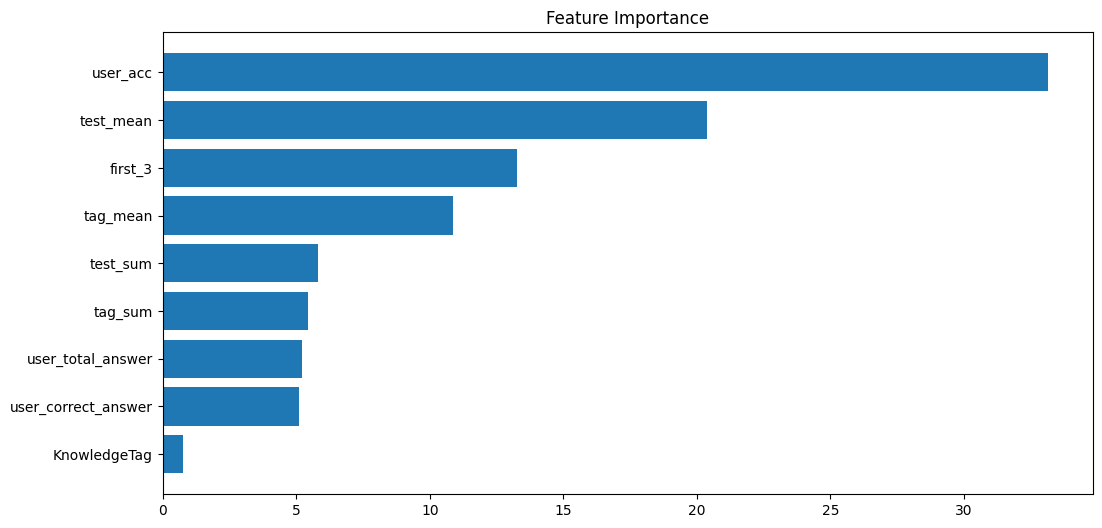

In [27]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(FEATS)[sorted_idx])
plt.title("Feature Importance")

In [28]:
test_data = pd.read_csv(os.path.join(data_dir, "test_data.csv"))
test_data.sort_values(by=["userID", "Timestamp"], inplace=True)

test_data = feature_engineering(test_data)

test_data = test_data[test_data.answerCode != -1]  # -1 인 answerCode 제외

# test데이터셋은 각 유저의 마지막 interaction만 추출
test_data = test_data[test_data["userID"] != test_data["userID"].shift(-1)]

y_test = test_data["answerCode"]
X_test = test_data.drop(["answerCode"], axis=1)

preds = model.predict(X_test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f"VALID AUC : {auc} ACC : {acc}")

VALID AUC : 0.7141174663321215 ACC : 0.6693548387096774


In [29]:
test_data = test_data[test_data["userID"] != test_data["userID"].shift(-1)]
test_data = test_data.drop(["answerCode"], axis=1)
total_preds = model.predict(X_test[FEATS])

In [30]:
# SAVE OUTPUT
output_dir = "/opt/ml/input/CatBoost_output"
write_path = os.path.join(output_dir, f"CatBoost_submission_{datetime.now().microsecond}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, "w", encoding="utf8") as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write("{},{}\n".format(id, p))

writing prediction : /opt/ml/input/CatBoost_output/CatBoost_submission_714408.csv
